In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("dark")

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
engagements = pd.read_csv('daily_engagement.csv')
enrollments = pd.read_csv('enrollments.csv')
submissions = pd.read_csv('project_submissions.csv')

# Remove test accounts
udacity_accts = set(enrollments[enrollments['is_udacity'] == True]['account_key'])

enrollments = enrollments[enrollments['is_udacity'] == False]
engagements = engagements[~engagements['account_key'].isin(udacity_accts)]
submissions = submissions[~submissions['account_key'].isin(udacity_accts)]

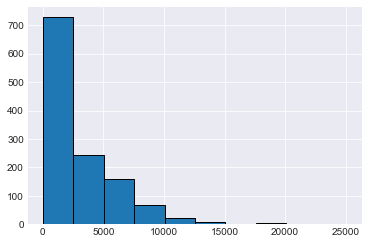

In [3]:
# Histogram of total minutes visited per student
engagements.groupby('account_key').sum().total_minutes_visited.hist(edgecolor='black')

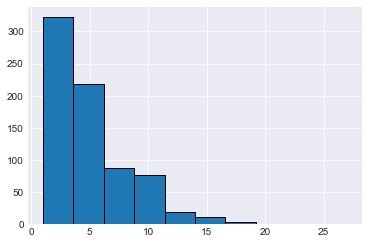

In [4]:
# Number of submissions per student
submissions['account_key'].value_counts().hist(edgecolor='black')

In [5]:
# Pivot: days as columns, students as rows, time as cells
data = engagements.pivot_table(index='account_key', columns='utc_date',
                                  values='total_minutes_visited').fillna(0)
data = data.reset_index()

completed_projects = engagements.groupby('account_key').sum()\
[['total_minutes_visited', 'lessons_completed', 'projects_completed']]

data = data.merge(submissions[['assigned_rating', 'account_key']],
                        how='left', on='account_key')

# Total time in the classroom
data['total_minutes'] = data.sum(axis=1)

# Completed projects (not used for machine learning)
data['projects'] = completed_projects['projects_completed']

# Make "passed" a binary variable
data['passed'] = np.where((data['assigned_rating'] == 'PASSED') |\
                             (data['assigned_rating'] == 'DISTINCTION'),
                            1, 0)

# Students can make multiple submissions. If a submission is eventually
# accepted, then the student should be marked passing for each previous
# submission. This is necessary for machine learning.
passing_students = set(data[data['passed'] == 1]['account_key'])
data['passed'] = np.where(data['account_key'].isin(passing_students), 1, 0)

In [6]:
# Collapse all submissions into a single record per student.
# This works because of the 'passed' feature we just created.
data = data.groupby('account_key').mean()

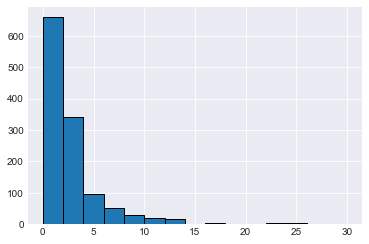

In [7]:
# Record how many days in a row a student logged in after initially joining

def streak(student):
    eng_count = []
    for i in student:
        if i > 0:
            eng_count.append(1)
        else:
            eng_count.append(0)

    for ix, val in enumerate(eng_count):
        if val > 0:
            eng_count = eng_count[ix:]
            break

    for ix, val in enumerate(eng_count):
        if val == 0:
            eng_count = eng_count[:ix]
            break

    return len(eng_count)

# You actually don't need to drop due to the way the function works,
# but it's a good practice to do it anyway.
data['streak'] = data.drop(['passed', 'projects', 'total_minutes'], axis=1).apply(streak, axis=1)

data['streak'].hist(bins=15, edgecolor='black')

In [8]:
# Record number of days the student logged in.
data['days_logged_in'] = data[data>0].drop(['total_minutes', 'projects', 'passed', 'streak'],
                                           axis=1).count(axis=1)

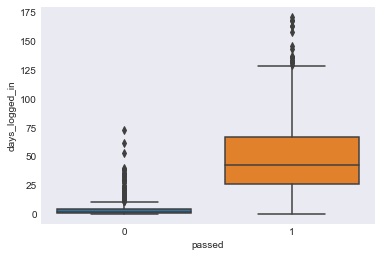

In [9]:
sns.boxplot(y='days_logged_in', x='passed', data=data)

# Machine Learning

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Shuffle (just in case)
data = data.sample(frac=1.0).fillna(0)

# All we'll look at is total time, days logged in, and initial streak
x = data[['days_logged_in', 'total_minutes', 'streak']]
y = data['passed']

clf = LogisticRegression()

cv = cross_val_score(clf, x, y, scoring='roc_auc', cv=4)

cv.mean(), cv.std()

(0.96558326666355965, 0.006577374322155132)

In [11]:
# XGBoost isn't much better!

clf = XGBClassifier(max_depth=2)

cv = cross_val_score(clf, x, y, scoring='roc_auc', cv=4)

cv.mean(), cv.std()

(0.96644867916174726, 0.0073332237731457504)

In [ ]:
# Code sandbox below (ignore!)

In [ ]:
engagements_sum = engagements.groupby('account_key').sum()
engagements_sum.columns = ['e_sum_' + str(i) for i in engagements_sum.columns]
engagements_count = engagements.groupby('account_key').count()
engagements_count.columns = ['e_count_' + str(i) for i in engagements_count.columns]
engagements_mean = engagements.groupby('account_key').mean()
engagements_mean.columns = ['e_mean_' + str(i) for i in engagements_mean.columns]

engagements_sum = engagements_sum.reset_index()
engagements_count = engagements_count.reset_index()
engagements_mean = engagements_mean.reset_index()

In [ ]:
enrollments = enrollments.merge(engagements_sum, how='outer', on='account_key')
enrollments = enrollments.merge(engagements_count, how='outer', on='account_key')
# enrollments = enrollments.merge(engagements_mean, how='outer', on='account_key')

In [ ]:
submissions = submissions.merge(enrollments, how='inner', on='account_key')

data = submissions.copy()
data = data[data.lesson_key == 3176718735]
for i in data.drop('assigned_rating', axis=1).columns:
    #if 'e_' not in i: del data[i]
    if 'projects_com' in i: del data[i]
    elif data[i].nunique() == 1: del data[i]

In [ ]:
y = np.where((data['assigned_rating'] == 'PASSED') |\
             (data['assigned_rating'] == 'DISTINCTION'),
              1, 0)
x = data.select_dtypes('number')

In [ ]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

xg = XGBRegressor(max_depth=2)

cv = cross_val_score(xg, x, y, scoring='roc_auc', cv=4)

cv.mean(), cv.std()

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

xg = LogisticRegression()

cv = cross_val_score(xg, x.fillna(x.median()), y, scoring='roc_auc', cv=4)

cv.mean(), cv.std()

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

xg = DecisionTreeClassifier(max_depth=3)

cv = cross_val_score(xg, x.fillna(x.median()), y, scoring='roc_auc', cv=4)

cv.mean(), cv.std()

In [ ]:
data.shape

In [ ]:
submissions